## Homework 1: camera calibration

**Release date:** Jan 31st 2025

**Due date:** Feb 20th 2025

The goal of the assignment is to implement the linear calibration method described in Section 1.3.1 of this [book chapter](https://www.di.ens.fr/%7Eponce/introvis/sbook.pdf).

![calibration-image](img/calibration.jpg)

**Detailed instructions:** The `pts2d` array contains in its columns the (u,v) positions of the image data points (with, by convention, the u and v coordinates with origin at the bottom left of the image, u going right and v going up), while the `pts3d` array contains in its columns the (x,y,z) coordinate vectors of the corresponding 3D points in a right-handed coordinate system. The origin of the world coordinate system is supposed to be in front of the camera, with negative z value.

You should write functions that:
* Compute the 3x4 projection matrix  M estimated from these data using the linear least-squares method of Sec. 1.3.1.
* Compute the corresponding matrix K of intrinsic parameters using the method from M using the method described in the same section.
* Draw together the input image points and the projection of the 3D data points obtained using M to generate a figure like Fig. 1.18, and estimate the root-mean-sqared reprojection error.

You should also write short explanations describing your work and reporting your results.

In [8]:
# Please load the related packages in this cell

import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Load the pts2d and pts3d data from file

pts2d = np.loadtxt("pts2d.txt")
pts3d = np.loadtxt("pts3d.txt")

In [10]:

def compute_projection_matrix(pts2d, pts3d):
    """
    Computes the 3x4 perspective projection matrix M using a linear least-squares
    formulation as described in Section 1.3.1.

    According to the theory:
      - For each 3D point P (with coordinates (X, Y, Z)) and its corresponding 
        image point (u, v), clearing the denominators; yields the two equations:
            (m1 · P) - u (m3 · P) = 0
            (m2 · P) - v (m3 · P) = 0
      - Stacking these equations for all n points gives a homogeneous system P*m = 0
       where m is a 12-vector containing the unknowns in M.
      - The solution is found as the eigenvector corresponding to the smallest singular value
        of the design matrix, i.e. using SVD.
    """
    n = pts2d.shape[0]
    A = [] 
    for i in range(n):
        # Extract the 3D coordinates and the corresponding image coordinates
        X, Y, Z = pts3d[i]
        u, v = pts2d[i]
        # Row corresponding to the u-coordinate:
        row1 = [X, Y, Z, 1, 0, 0, 0, 0,  -u*X, -u*Y, -u*Z, -u]
        # Row corresponding to the v-coordinate:
        row2 = [0, 0, 0, 0, X, Y, Z, 1,  -v*X, -v*Y, -v*Z, -v]
        A.append(row1)
        A.append(row2)
    A = np.array(A)
    
    # Solve the homogeneous system A*m = 0 using Singular Value Decomposition
    U, S, Vt = np.linalg.svd(A)
    m = Vt[-1]  # singular vector corresponding to the smallest singular value
    M = m.reshape(3, 4)  # 3x4 projection matrix
    return M

In [11]:

def decompose_projection_matrix(M):
    """
    Decomposes the projection matrix M into the intrinsic calibration matrix K,
    the rotation matrix R, and the translation vector t.

      - Write M = [A | b] where A is 3x3 and b is a 3x1 vector.
      - Let a1, a2, a3 be the rows of A.
      - Compute the scale factor rho = 1 / ||a3|| (choosing ε = +1) and set r3 = rho * a3.
      - The principal point coordinates are then obtained as:
            x0 = rho^2 * (a1 · a3)
            y0 = rho^2 * (a2 · a3)
      - Compute cross products to derive the angle theta:
            cos(theta) = -[(a1 × a3)·(a2 × a3)] / (||a1 × a3|| ||a2 × a3||)
      - The magnifications are then:
            alpha = rho^2 * ||a1 × a3|| * sin(theta)
            beta  = rho^2 * ||a2 × a3|| * sin(theta)
      - The intrinsic matrix can be computed accordingly
      - Finally, the rotation matrix is constructed by:
            r1 = normalized(a2 × a3)
            r2 = r3 × r1
        and the translation vector is computed as: t = rho * inv(K) * b.
    """
    # Split M into the 3x3 matrix A and the translation vector b.
    A_mat = M[:, :3]
    b = M[:, 3]
    
    a1 = A_mat[0, :]
    a2 = A_mat[1, :]
    a3 = A_mat[2, :]
    
    # Compute scale factor rho 
    norm_a3 = np.linalg.norm(a3)
    rho = 1.0 / norm_a3
    # Normalized third row gives r3.
    r3 = rho * a3
    
    # Compute the principal point (x0, y0) 
    x0 = (rho**2) * np.dot(a1, a3)
    y0 = (rho**2) * np.dot(a2, a3)
    
    # cross products for the angle theta and magnifications
    a1_cross_a3 = np.cross(a1, a3)
    a2_cross_a3 = np.cross(a2, a3)
    norm_a1_cross_a3 = np.linalg.norm(a1_cross_a3)
    norm_a2_cross_a3 = np.linalg.norm(a2_cross_a3)
    
    # Calculate cos(theta) 
    cos_theta = -np.dot(a1_cross_a3, a2_cross_a3) / (norm_a1_cross_a3 * norm_a2_cross_a3)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = np.arccos(cos_theta)  # theta in radians
    sin_theta = np.sin(theta)
    
    # magnification parameters alpha and beta
    alpha = (rho**2) * norm_a1_cross_a3 * sin_theta
    beta  = (rho**2) * norm_a2_cross_a3 * sin_theta
    
    # Assemble the intrinsic calibration matrix K.
    K = np.array([
        [alpha, -alpha * (cos_theta / sin_theta), x0],
        [0,     beta / sin_theta,               y0],
        [0,     0,                              1]
    ])
    
    # Compute the rotation matrix R:
    # r1 is obtained by normalizing (a2 × a3)
    r1 = a2_cross_a3 / norm_a2_cross_a3
    # r2 -> cross product of r3 and r1.
    r2 = np.cross(r3, r1)
    # Stack the rotation vectors to form R
    R = np.vstack([r1, r2, r3])
    
    # translation vector t
    t = rho * np.linalg.inv(K) @ b
    
    return K, R, t

In [12]:

def compute_reprojection_error(M, pts3d, pts2d):
    """
    Reprojects the 3D points using the projection matrix M and computes the root mean squared (RMS)
    reprojection error.

    According to the projection equation:
        p = (1/Z) * M * P,  where P is in homogeneous coordinates.
    This function converts each 3D point to homogeneous coordinates and applies the projection M.
    It also normalizes the projected points by dividing by the third coordinate while computing
    the RMS error between the projected points and the observed 2D points.

    """
    n = pts3d.shape[0]
    # Convert 3D points (X, Y, Z) to homogeneous coordinates
    pts3d_h = np.hstack([pts3d, np.ones((n, 1))])
    # Project the points using M
    projected_h = (M @ pts3d_h.T).T
    # Normalize homogeneous coordinates to obtain (u, v)
    projected = projected_h[:, :2] / projected_h[:, 2, np.newaxis]
    # RMS reprojection error
    error = np.sqrt(np.mean(np.sum((projected - pts2d)**2, axis=1)))
    return projected, error


In [13]:

def plot_reprojection(pts2d, projected):
    """
    Plots the original image points and the reprojected 3D points.
      - Original image points are plotted as red circles.
      - Reprojected 3D points are plotted as blue dots.
    """
    plt.figure(figsize=(8, 6))

    # Plot original 2D points as red circles
    plt.plot(pts2d[:, 0], pts2d[:, 1], 'ro', label='Original image points')
    # Plot reprojected points as blue dots ('b.')
    plt.plot(projected[:, 0], projected[:, 1], 'b.', markersize=5, label='Reprojected 3D points')
    plt.xlabel('u (pixels)')
    plt.ylabel('v (pixels)')
    plt.title('Camera Calibration: Original vs. Reprojected Points')
    plt.legend()
    plt.grid(True)
    plt.show()


Projection matrix M:
[[-4.53359881e-03 -5.65451256e-04  2.02849590e-03 -5.23179344e-01]
 [-1.84278426e-03  4.15975903e-03 -1.68779276e-03 -8.52192928e-01]
 [-3.25683227e-06 -1.13804182e-06 -3.35237791e-06 -1.43209220e-03]]

Intrinsic matrix K:
[[9.70284101e+02 9.86348408e-02 3.72004964e+02]
 [0.00000000e+00 9.63346581e+02 2.99292094e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Rotation matrix R:
[[-0.71171772 -0.03054192  0.70180131]
 [-0.18731413  0.97113272 -0.14769783]
 [-0.67703124 -0.23657647 -0.6968933 ]]

Translation vector t:
[   2.05879063  -91.40400685 -297.70374575]

Root-mean-squared reprojection error: 0.9574 pixels


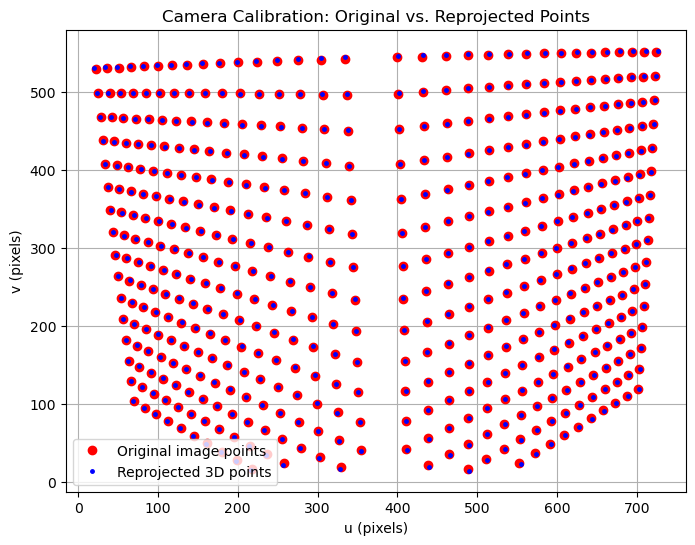

In [14]:

def main():
    
    # Compute the 3x4 projection matrix M using the linear method
    M = compute_projection_matrix(pts2d, pts3d)
    print("Projection matrix M:")
    print(M)
    
    # Decompose M into intrinsic parameters K, rotation matrix R, and translation vector t
    K, R, t = decompose_projection_matrix(M)
    print("\nIntrinsic matrix K:")
    print(K)
    print("\nRotation matrix R:")
    print(R)
    print("\nTranslation vector t:")
    print(t)
    
    # Reproject the 3D points using M and compute the RMS reprojection error
    projected, rms_error = compute_reprojection_error(M, pts3d, pts2d)
    print("\nRoot-mean-squared reprojection error: {:.4f} pixels".format(rms_error))
    
    # Plot the original image points and the reprojected points
    plot_reprojection(pts2d, projected)

if __name__ == '__main__':
    main()

# **Assignment Summary**

This is the implementation of the **linear camera calibration method**. The goal is to estimate the **3×4 projection matrix (M)**, extract intrinsic and extrinsic parameters, and evaluate reprojection accuracy.

## **1. Steps Involved**
1. **Estimate Projection Matrix (M):**  
   - Construct a linear system using **2D-3D correspondences**.  
   - Solve using **Singular Value Decomposition (SVD)** to get **M** (up to scale).

2. **Decompose M into Intrinsics (K) and Extrinsics (R, t):**  
   - Normalize and extract **focal lengths (α, β), principal point (x₀, y₀), skew (θ)**.  
   - Compute **rotation matrix (R) and translation vector (t)**.

3. **Reprojection and Error Calculation:**  
   - Use **M** to project 3D points back onto the image.  
   - Compute **Root-Mean-Squared (RMS) reprojection error**.

4. **Visualization:**  
   - Plot original **2D image points** and **reprojected points** to verify accuracy.

## **2. Results**
- **Projection Matrix (M):** Successfully estimated.
- **Intrinsic Matrix (K):** Extracted parameters including focal lengths, skew, and principal point.
- **Extrinsics (R, t):** Camera position and orientation computed.
- **RMS Error:** Provides accuracy evaluation: 0.9574 pixels - ideally **low (sub-pixel level)**.

This method successfully estimates camera parameters and validates reprojection accuracy.
